<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [None](https://jckantor.github.io/cbe30338-2021/03.04-Implementing-Controllers.html) | [Contents](toc.html) | [3.6 Lab Assignment 3: Relay and PI Control](https://jckantor.github.io/cbe30338-2021/03.06-Lab-Assignment-PID-Control.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.05-Proportional-Integral-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.05-Proportional-Integral-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 3.5 Proportional (P) and Proportional-Integral (PI) Control

## 3.5.1 Proportional (P) Control

Unlike the on-off nature of relay control, proportional control adjusts the value of the manipulated variable in proportional to the size of the error between the setpoint and measured process variable.

\begin{align}
MV_k & = \bar{MV} + K_P(SP_k  - PV_k)
\end{align}

$K_p$ is a constant of proportionality called the **proportional control gain**.

The initial term $\bar{MV}$ provides an initial estimate for the value of the manipulated variable constructed from whatever knowledge may be available.

In [8]:
def P(Kp, MV_bar, MV_min, MV_max):
    MV = MV_min
    while True:
        PV, SP = yield MV
        e = SP - PV
        MV = MV_bar + Kp*e
        MV = max(MV_min, min(MV_max, MV))

Let's see how well proportional control works when applied to the Temperature Control Laboratory. For this simulation we will arbitrarily set $\bar{MV} = 0$ and $K_p = 3.0$.

Note that the only line that has to change from the use of relay control is specification of the controller

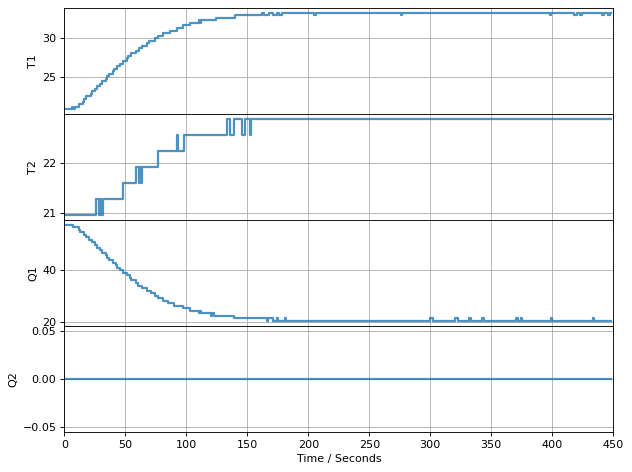

TCLab Model disconnected successfully.


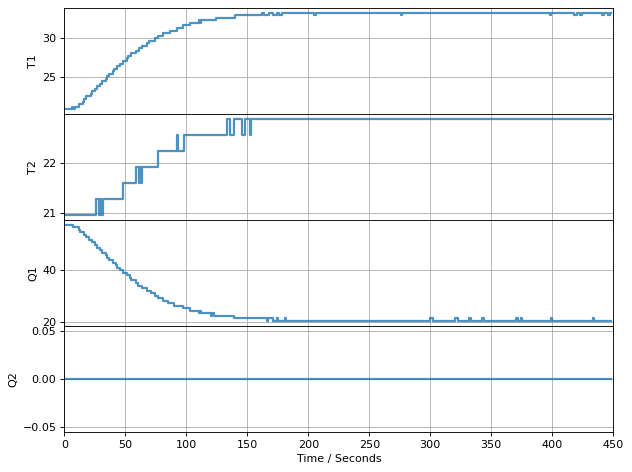

In [12]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

TCLab = setup(connected=False, speedup=20)

# control parameters
controller = P(Kp=3.0, MV_bar=0.0, MV_min=0, MV_max=100)
controller.send(None)
T_SP = 40

# time horizon and time step
t_final = 450

# perform experiment
with TCLab() as lab:
    lab.P1 = 200
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    for t in clock(t_final):
        T1 = lab.T1
        U1 = controller.send((T1, T_SP))
        lab.Q1(U1)
        p.update(t)    

With appropriate parameter choices, proportional control can be effective in achieving a fast response to changes in input and to disturbance inputs. However, note that at steady state, the measured temperature is significantly different than the desired setpoint. This steady-state error is generally unacceptable, and a major short coming of purely proportional control.

<hr>

**Study Question:** Test the simulation for values of $K_p$ that are twice as large, and half as large as demonstrated above. What do you notice about the steady-state error between the desired setpoint and the measured process variable?

<hr>

## 3.5.2 Proportional-Integral (PI) Control

Given a process variable $PV$ and setpoint $SP$, proportional-integral control determines the value of a manipulated variable MV by the rule

\begin{align}
MV_k & = \bar{MV} + K_P(SP_k  - PV_k) + K_I\sum_{j=0}^{j=k} (SP_j -  PV_j)
\end{align}

where $K_P$ and $K_I$ are the proportional and integral gains, respectively.

### 3.5.2.1 Implementation of a simple PI controller

The actual implementation of PI control is normally done by computing how much the $MV$ should change at each time step. Defining the error at time $k$ as

\begin{align}
e_k & = SP_k - PV_k
\end{align}

then consecutive values of $MV$ are given by 

\begin{align}
MV_{k-1} & = \bar{MV} + K_p e_{k-1} + K_i \sum_{j=0}^{k-1} e_{j} \\
MV_{k} & = \bar{MV} + K_p e_{k} + K_i \sum_{j=0}^{k} e_{j}
\end{align}

Taking differences gives a practical formula for updating the value of $MV$ in response to measurements

\begin{align}
MV_{k} & = MV_{k-1} + K_p(e_{k} - e_{k-1}) + K_i e_{k}
\end{align}

In [ ]:
def PI(Kp, Ki, MV_min, MV_max):
    MV = MV_min
    e_prev = 0
    while True:
        PV, SP = yield MV
        e = SP - PV
        MV = MV + Kp*(e - e_prev) + Ki*e
        MV = max(MV_min, min(MV_max, MV))
        e_prev = e

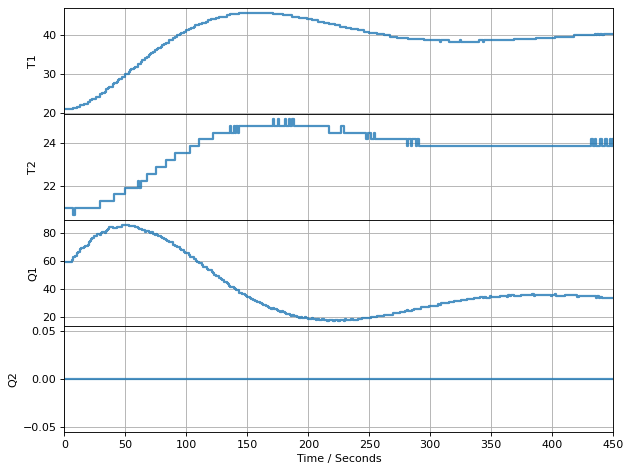

TCLab Model disconnected successfully.


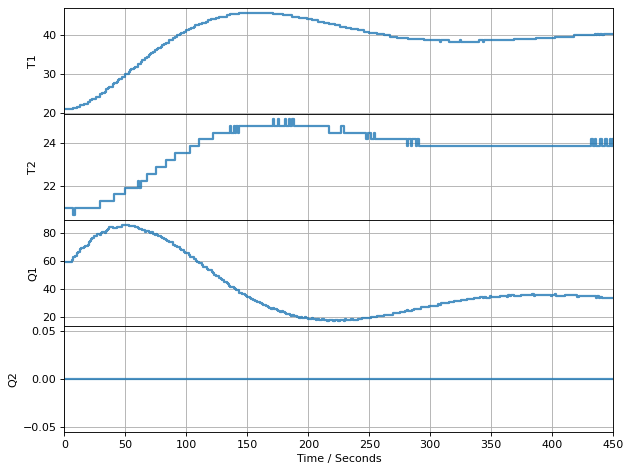

In [7]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

TCLab = setup(connected=False, speedup=20)

# control parameters
controller = PI(3, 0.1, MV_min=0, MV_max=100)
controller.send(None)
T_SP = 40

# time horizon and time step
t_final = 450

# perform experiment
with TCLab() as lab:
    lab.P1 = 200
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    for t in clock(t_final):
        T1 = lab.T1
        U1 = controller.send((T1, T_SP))
        lab.Q1(U1)
        p.update(t)    

<!--NAVIGATION-->
< [None](https://jckantor.github.io/cbe30338-2021/03.04-Implementing-Controllers.html) | [Contents](toc.html) | [3.6 Lab Assignment 3: Relay and PI Control](https://jckantor.github.io/cbe30338-2021/03.06-Lab-Assignment-PID-Control.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.05-Proportional-Integral-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.05-Proportional-Integral-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>